In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class TwoBodyProblem:
    def __init__(self, m1, m2, G=1.0):
        """
        Inicializa el problema de dos cuerpos.

        Args:
            m1, m2: masas de los cuerpos
            G: constante gravitacional
        """
        self.m1 = m1
        self.m2 = m2
        self.G = G
        self.mu = m1 * m2 / (m1 + m2)  # masa reducida

    def equations_of_motion(self, t, y):
        """
        Define las ecuaciones de movimiento hamiltonianas.

        Args:
            t: tiempo
            y: vector de estado [rx, ry, rz, px, py, pz]

        Returns:
            derivadas del vector de estado
        """
        r = y[:3]  # posición relativa
        p = y[3:]  # momento conjugado

        r_norm = np.linalg.norm(r)

        # Derivadas de posición
        dr_dt = p / self.mu

        # Derivadas de momento
        dp_dt = -self.G * self.m1 * self.m2 * r / r_norm**3

        return np.concatenate([dr_dt, dp_dt])

    def rk4_step(self, t, y, h):
        """
        Realiza un paso del método Runge-Kutta de orden 4.

        Args:
            t: tiempo actual
            y: estado actual
            h: paso temporal

        Returns:
            nuevo estado después del paso
        """
        k1 = h * self.equations_of_motion(t, y)
        k2 = h * self.equations_of_motion(t + h/2, y + k1/2)
        k3 = h * self.equations_of_motion(t + h/2, y + k2/2)
        k4 = h * self.equations_of_motion(t + h, y + k3)

        return y + (k1 + 2*k2 + 2*k3 + k4) / 6

    def integrate(self, y0, t_span, h):
        """
        Integra las ecuaciones de movimiento usando RK4.

        Args:
            y0: condiciones iniciales [rx0, ry0, rz0, px0, py0, pz0]
            t_span: tupla (t_inicial, t_final)
            h: paso temporal

        Returns:
            arrays de tiempo y estados
        """
        t_start, t_end = t_span
        n_steps = int((t_end - t_start) / h) + 1

        times = np.linspace(t_start, t_end, n_steps)
        states = np.zeros((n_steps, 6))

        states[0] = y0

        for i in range(1, n_steps):
            states[i] = self.rk4_step(times[i-1], states[i-1], h)

        return times, states

    def compute_conserved_quantities(self, states):
        """
        Calcula las cantidades conservadas durante la integración.

        Args:
            states: array de estados

        Returns:
            energía y momento angular para cada estado
        """
        energies = []
        angular_momenta = []

        for state in states:
            r = state[:3]
            p = state[3:]

            # Energía
            kinetic = np.linalg.norm(p)**2 / (2 * self.mu)
            potential = -self.G * self.m1 * self.m2 / np.linalg.norm(r)
            energy = kinetic + potential
            energies.append(energy)

            # Momento angular
            L = np.cross(r, p)
            angular_momenta.append(np.linalg.norm(L))

        return np.array(energies), np.array(angular_momenta)

# Ejemplo de uso básico
def simulate_kepler_orbit():
    """Simula una órbita kepleriana básica."""

    # Parámetros del sistema
    m1, m2 = 1.0, 0.001  # masa estrella y planeta
    G = 1.0
    problem = TwoBodyProblem(m1, m2, G)

    # Condiciones iniciales para órbita elíptica
    r0 = np.array([1.0, 0.0, 0.0])  # posición inicial
    v0 = np.array([0.0, 0.8, 0.0])   # velocidad inicial
    p0 = problem.mu * v0             # momento inicial

    y0 = np.concatenate([r0, p0])

    # Integración
    t_span = (0, 20)  # tiempo de integración
    h = 0.01          # paso temporal

    times, states = problem.integrate(y0, t_span, h)

    # Verificación de conservación
    energies, angular_momenta = problem.compute_conserved_quantities(states)

    return times, states, energies, angular_momenta

if __name__ == "__main__":
    times, states, energies, L_values = simulate_kepler_orbit()
    print(f"Conservación de energía: {np.std(energies)/np.abs(np.mean(energies)):.6e}")
    print(f"Conservación de momento angular: {np.std(L_values)/np.mean(L_values):.6e}")


Conservación de energía: 5.898445e-09
Conservación de momento angular: 1.227567e-09


In [ ]:
def plot_orbit_2d(times, states, title="Órbita en el Plano XY"):
    """
    Grafica la órbita en 2D.

    Args:
        times: array de tiempos
        states: array de estados
        title: título del gráfico
    """
    positions = states[:, :3]

    plt.figure(figsize=(10, 8))
    plt.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='Órbita')
    plt.plot(positions[0, 0], positions[0, 1], 'go', markersize=8, label='Inicio')
    plt.plot(0, 0, 'r*', markersize=15, label='Centro de masa')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

def plot_orbit_3d(times, states, title="Órbita en 3D"):
    """
    Grafica la órbita en 3D.

    Args:
        times: array de tiempos
        states: array de estados
        title: título del gráfico
    """
    positions = states[:, :3]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
            'b-', linewidth=2, label='Órbita')
    ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2],
               c='g', s=100, label='Inicio')
    ax.scatter(0, 0, 0, c='r', s=200, marker='*', label='Centro de masa')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_conserved_quantities(times, energies, angular_momenta):
    """
    Grafica la evolución de las cantidades conservadas.

    Args:
        times: array de tiempos
        energies: array de energías
        angular_momenta: array de momentos angulares
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Energía
    ax1.plot(times, energies, 'b-', linewidth=2)
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('Energía')
    ax1.set_title('Conservación de Energía')
    ax1.grid(True, alpha=0.3)

    # Momento angular
    ax2.plot(times, angular_momenta, 'r-', linewidth=2)
    ax2.set_xlabel('Tiempo')
    ax2.set_ylabel('Momento Angular')
    ax2.set_title('Conservación de Momento Angular')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Función para generar múltiples órbitas
def compare_orbits():
    """Compara órbitas con diferentes excentricidades."""

    m1, m2 = 1.0, 0.001
    G = 1.0
    problem = TwoBodyProblem(m1, m2, G)

    # Diferentes condiciones iniciales para diferentes excentricidades
    initial_conditions = [
        ([1.0, 0.0, 0.0], [0.0, 1.0, 0.0]),   # circular
        ([1.0, 0.0, 0.0], [0.0, 0.8, 0.0]),   # elíptica
        ([1.0, 0.0, 0.0], [0.0, 0.5, 0.0]),   # muy elíptica
    ]

    labels = ['Circular', 'Elíptica', 'Muy Elíptica']
    colors = ['blue', 'red', 'green']

    plt.figure(figsize=(12, 10))

    for i, ((r0, v0), label, color) in enumerate(zip(initial_conditions, labels, colors)):
        r0 = np.array(r0)
        v0 = np.array(v0)
        p0 = problem.mu * v0
        y0 = np.concatenate([r0, p0])

        times, states = problem.integrate(y0, (0, 15), 0.01)
        positions = states[:, :3]

        plt.plot(positions[:, 0], positions[:, 1],
                color=color, linewidth=2, label=label)

    plt.plot(0, 0, 'k*', markersize=15, label='Centro de masa')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Comparación de Órbitas con Diferentes Excentricidades')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

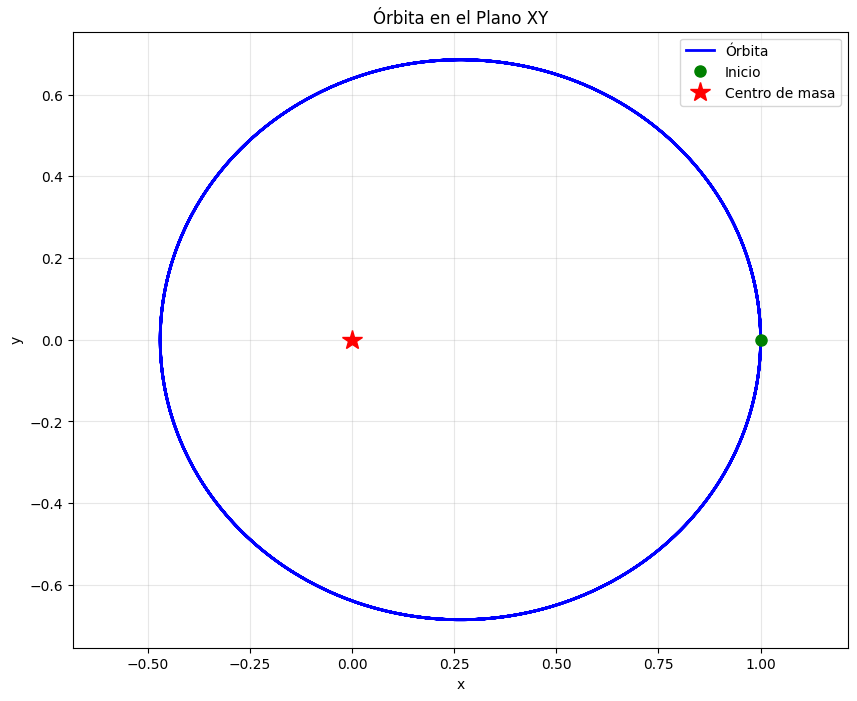

In [ ]:
plot_orbit_2d(times, states, title="Órbita en el Plano XY")

Mostrando gráfica 2D de la órbita...


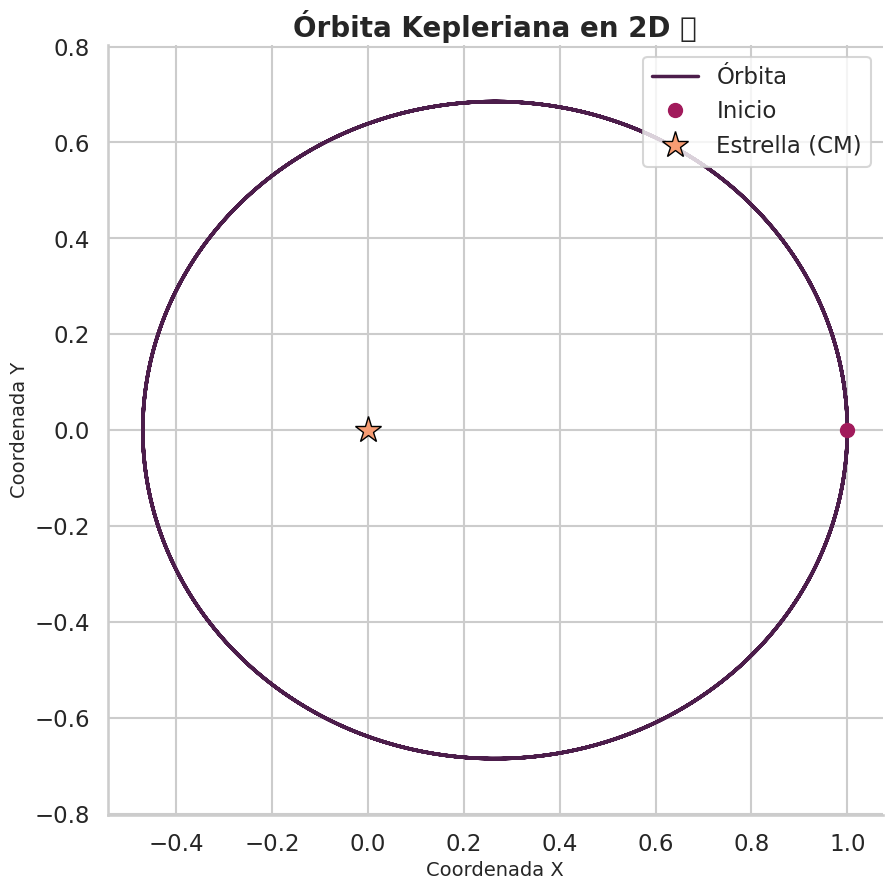

Mostrando gráfica 3D de la órbita...


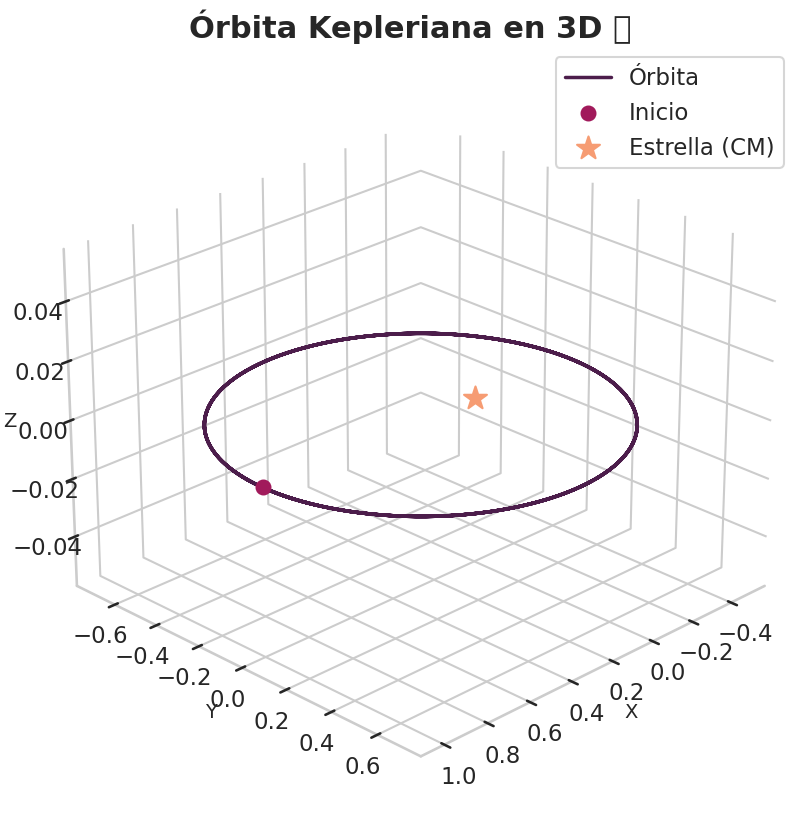

Mostrando gráficas de conservación de energía y momento angular...


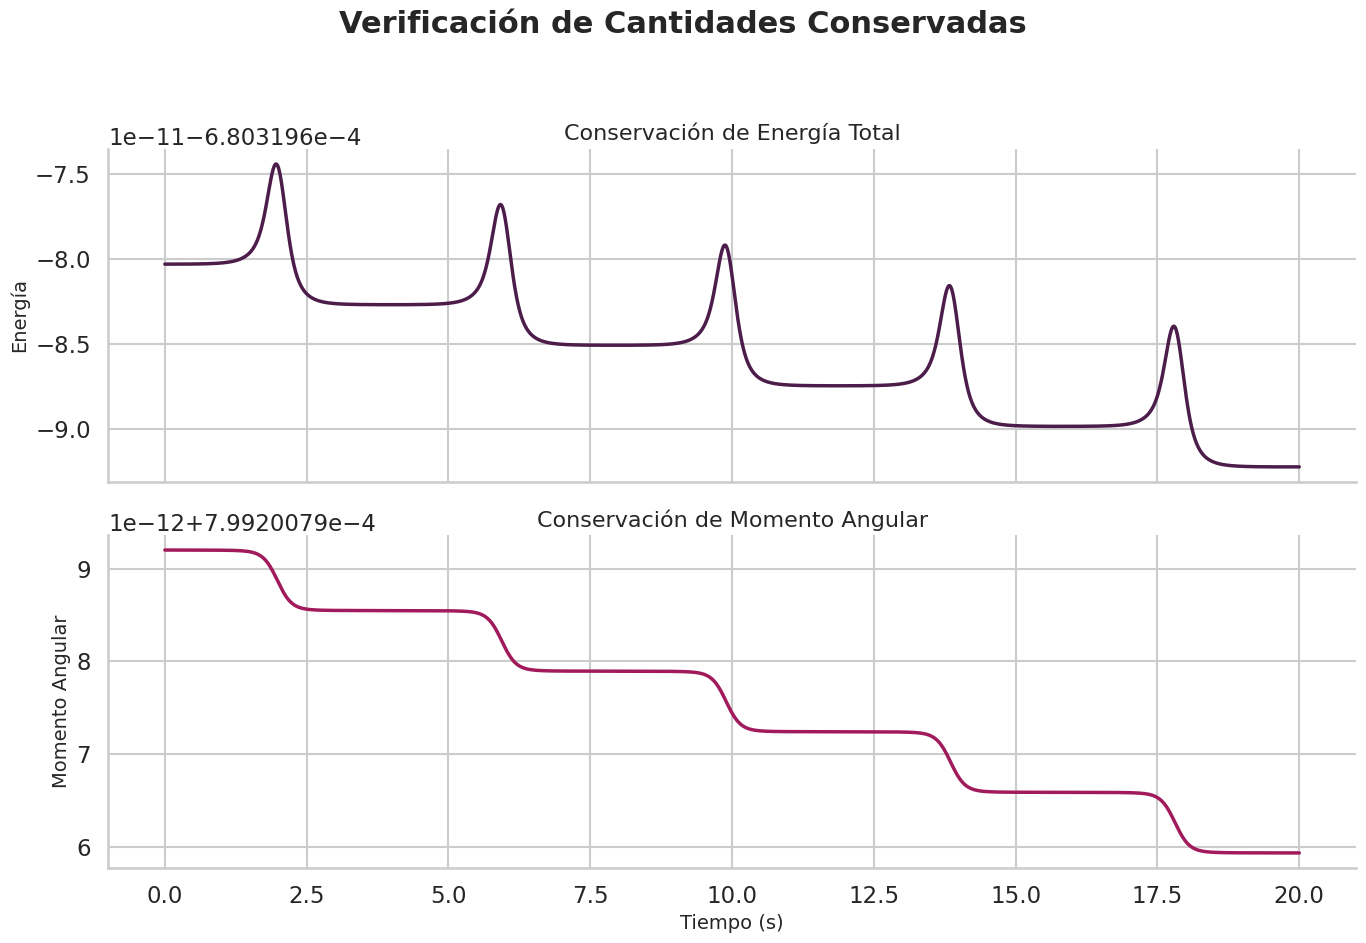

Mostrando comparación de diferentes órbitas...


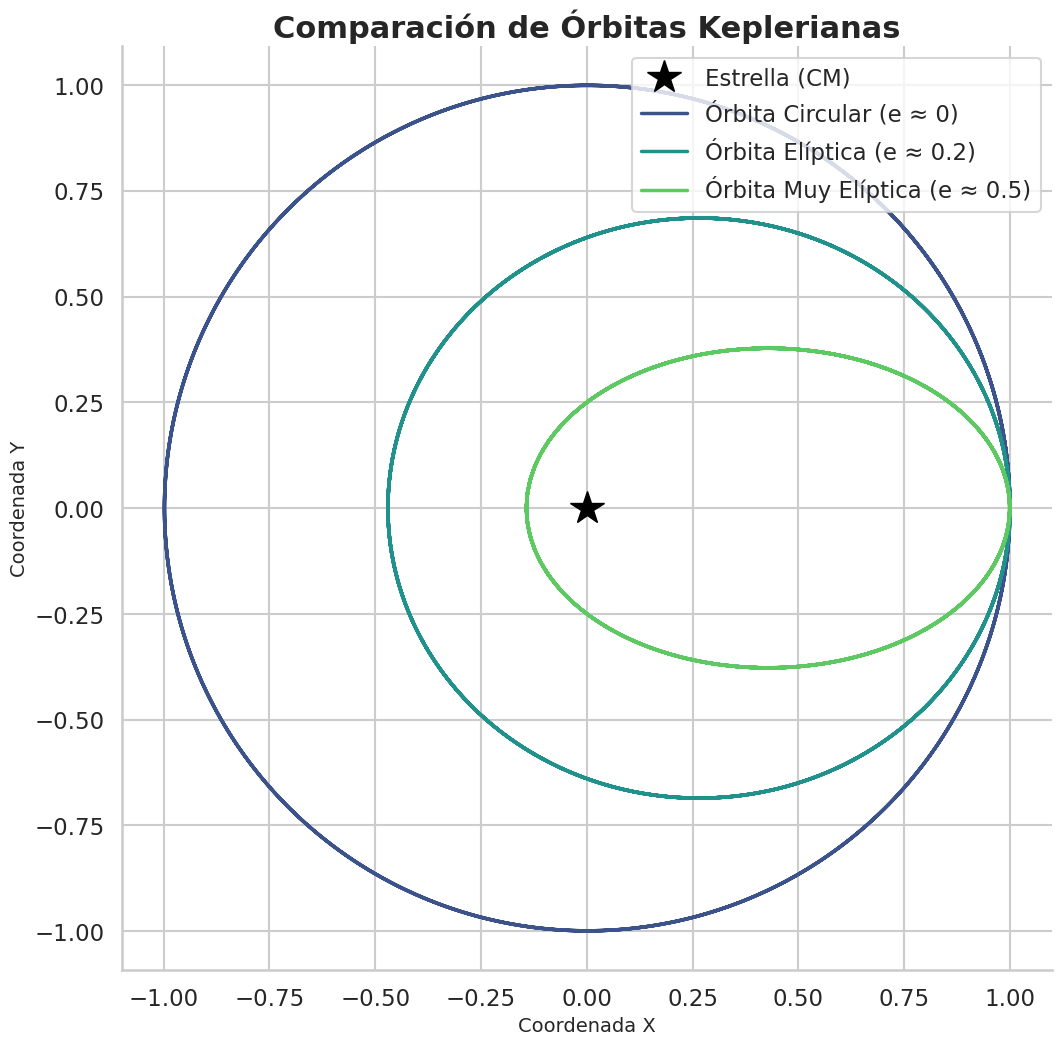

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# --- Configuración Estética Global con Seaborn ---
# Aplica un estilo visual profesional y limpio con una cuadrícula blanca.
sns.set_style("whitegrid")
# Ajusta el tamaño de fuentes, líneas y otros elementos para una presentación tipo "charla".
sns.set_context("talk")
# Crea una paleta de colores de alta calidad.
palette = sns.color_palette("rocket", 4) # Usaremos esta paleta en las gráficas.

# -----------------------------------------------------------------------------
# Aquí iría la definición de la clase TwoBodyProblem del código anterior
# class TwoBodyProblem:
#     ...
#
# def simulate_kepler_orbit():
#     ...
# -----------------------------------------------------------------------------


def plot_orbit_2d(states, title="Órbita Kepleriana en 2D 🪐"):
    """
    Grafica la órbita en 2D con un estilo mejorado.
    """
    positions = states[:, :3]

    plt.figure(figsize=(10, 10))

    # Dibuja la órbita con un color de la paleta y mayor grosor.
    plt.plot(positions[:, 0], positions[:, 1], color=palette[0], lw=2.5, label='Órbita')

    # Marca el inicio y el centro de masa con estilos claros y modernos.
    plt.plot(positions[0, 0], positions[0, 1], 'o', color=palette[1], markersize=10, label='Inicio')
    plt.plot(0, 0, '*', color=palette[3], markersize=20, markeredgecolor='black', label='Estrella (CM)')

    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel('Coordenada X', fontsize=14)
    plt.ylabel('Coordenada Y', fontsize=14)
    plt.legend(frameon=True, loc='upper right')
    plt.axis('equal') # Mantiene la proporción de los ejes.

    # Elimina los bordes superior y derecho para un look más limpio.
    sns.despine()
    plt.show()


def plot_orbit_3d(states, title="Órbita Kepleriana en 3D 🌌"):
    """
    Grafica la órbita en 3D con mejoras estéticas.
    """
    positions = states[:, :3]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Dibuja la órbita en 3D.
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
            color=palette[0], lw=2.5, label='Órbita')

    # Dibuja los puntos de inicio y centro de masa.
    ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2],
               c=[palette[1]], s=100, label='Inicio', depthshade=False)
    ax.scatter(0, 0, 0, c=[palette[3]], s=300, marker='*', label='Estrella (CM)', depthshade=False)

    # Mejora la estética del fondo y la cuadrícula.
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.grid(linestyle='--', alpha=0.6)

    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    ax.set_zlabel('Z', fontsize=14)
    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.legend()

    # Ajusta el ángulo de vista para una mejor perspectiva.
    ax.view_init(elev=25, azim=45)
    plt.show()


def plot_conserved_quantities(times, energies, angular_momenta):
    """
    Grafica la energía y el momento angular con un estilo mejorado.
    """
    # Crea una figura con 2 subplots.
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    fig.suptitle('Verificación de Cantidades Conservadas', fontsize=22, fontweight='bold')

    # Gráfica de Energía
    ax1.plot(times, energies, color=palette[0], lw=2.5)
    ax1.set_ylabel('Energía', fontsize=14)
    ax1.set_title('Conservación de Energía Total', fontsize=16)

    # Gráfica de Momento Angular
    ax2.plot(times, angular_momenta, color=palette[1], lw=2.5)
    ax2.set_ylabel('Momento Angular', fontsize=14)
    ax2.set_xlabel('Tiempo (s)', fontsize=14)
    ax2.set_title('Conservación de Momento Angular', fontsize=16)

    # Elimina spines innecesarios.
    sns.despine(fig=fig)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para que el supertítulo no se solape
    plt.show()


def compare_orbits():
    """
    Compara órbitas con diferentes excentricidades usando una paleta de colores.
    """
    # Asumimos que la clase TwoBodyProblem ya está definida
    problem = TwoBodyProblem(m1=1.0, m2=0.001, G=1.0)

    initial_conditions = [
        ([1.0, 0.0, 0.0], [0.0, 1.0, 0.0]),   # Circular
        ([1.0, 0.0, 0.0], [0.0, 0.8, 0.0]),   # Elíptica
        ([1.0, 0.0, 0.0], [0.0, 0.5, 0.0]),   # Muy Elíptica
    ]
    labels = ['Órbita Circular (e ≈ 0)', 'Órbita Elíptica (e ≈ 0.2)', 'Órbita Muy Elíptica (e ≈ 0.5)']

    # Usa una paleta de seaborn para colores distintivos y agradables.
    colors = sns.color_palette("viridis", len(initial_conditions))

    plt.figure(figsize=(12, 12))

    # Estrella (se dibuja una sola vez)
    plt.plot(0, 0, '*', color='black', markersize=25, label='Estrella (CM)', zorder=5)

    for i, ((r0, v0), label) in enumerate(zip(initial_conditions, labels)):
        p0 = problem.mu * np.array(v0)
        y0 = np.concatenate([np.array(r0), p0])
        times, states = problem.integrate(y0, (0, 20), 0.01)
        positions = states[:, :3]

        plt.plot(positions[:, 0], positions[:, 1],
                 color=colors[i], lw=2.5, label=label)

    plt.title('Comparación de Órbitas Keplerianas', fontsize=22, fontweight='bold')
    plt.xlabel('Coordenada X', fontsize=14)
    plt.ylabel('Coordenada Y', fontsize=14)
    plt.legend(frameon=True, loc='upper right')
    plt.axis('equal')
    sns.despine()
    plt.show()


# --- Ejemplo de Uso ---
if __name__ == '__main__':
    # Genera datos para una órbita de ejemplo
    times, states, energies, L_values = simulate_kepler_orbit()

    # Llama a las nuevas funciones de graficación
    print("Mostrando gráfica 2D de la órbita...")
    plot_orbit_2d(states)

    print("Mostrando gráfica 3D de la órbita...")
    plot_orbit_3d(states)

    print("Mostrando gráficas de conservación de energía y momento angular...")
    plot_conserved_quantities(times, energies, L_values)

    print("Mostrando comparación de diferentes órbitas...")
    compare_orbits()

Simulando órbitas básicas...


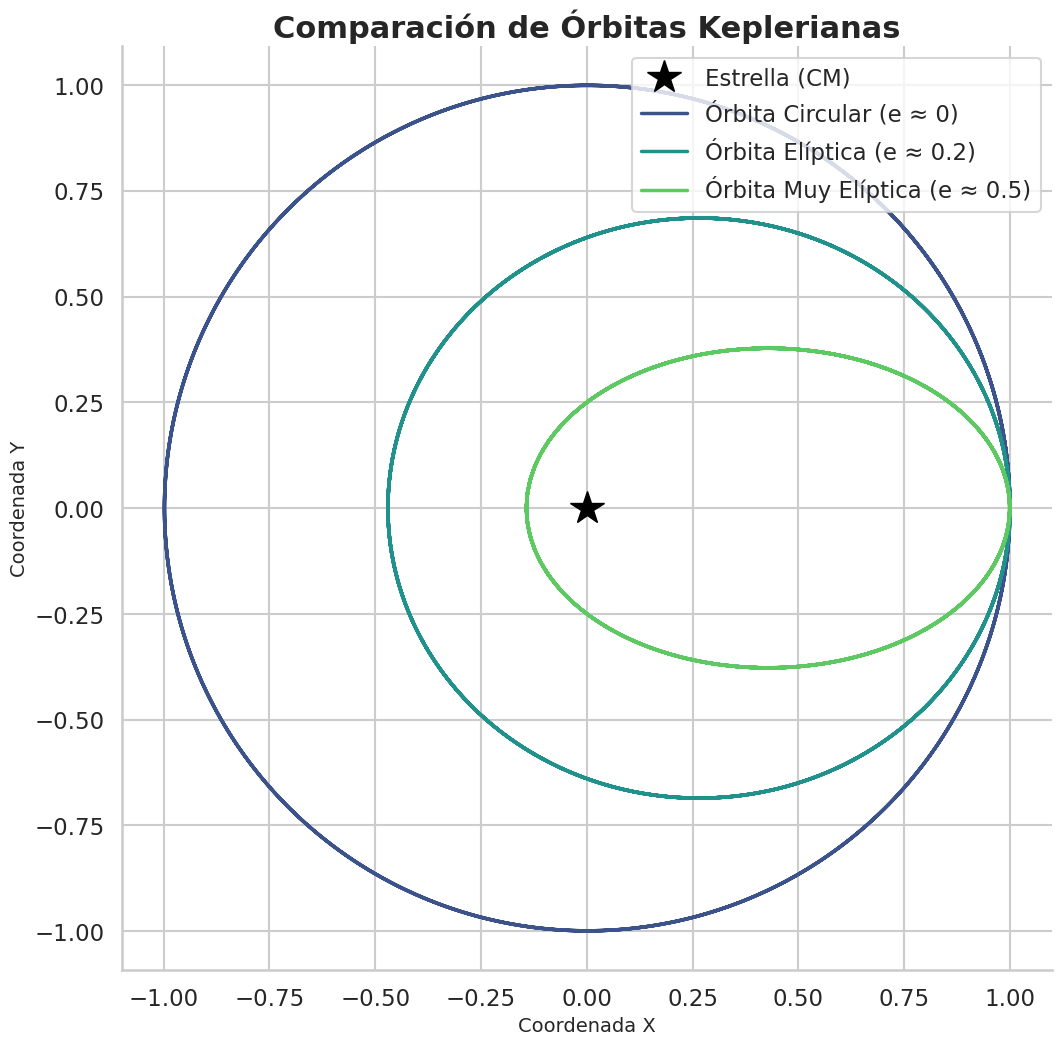

Simulando órbitas perturbadas...


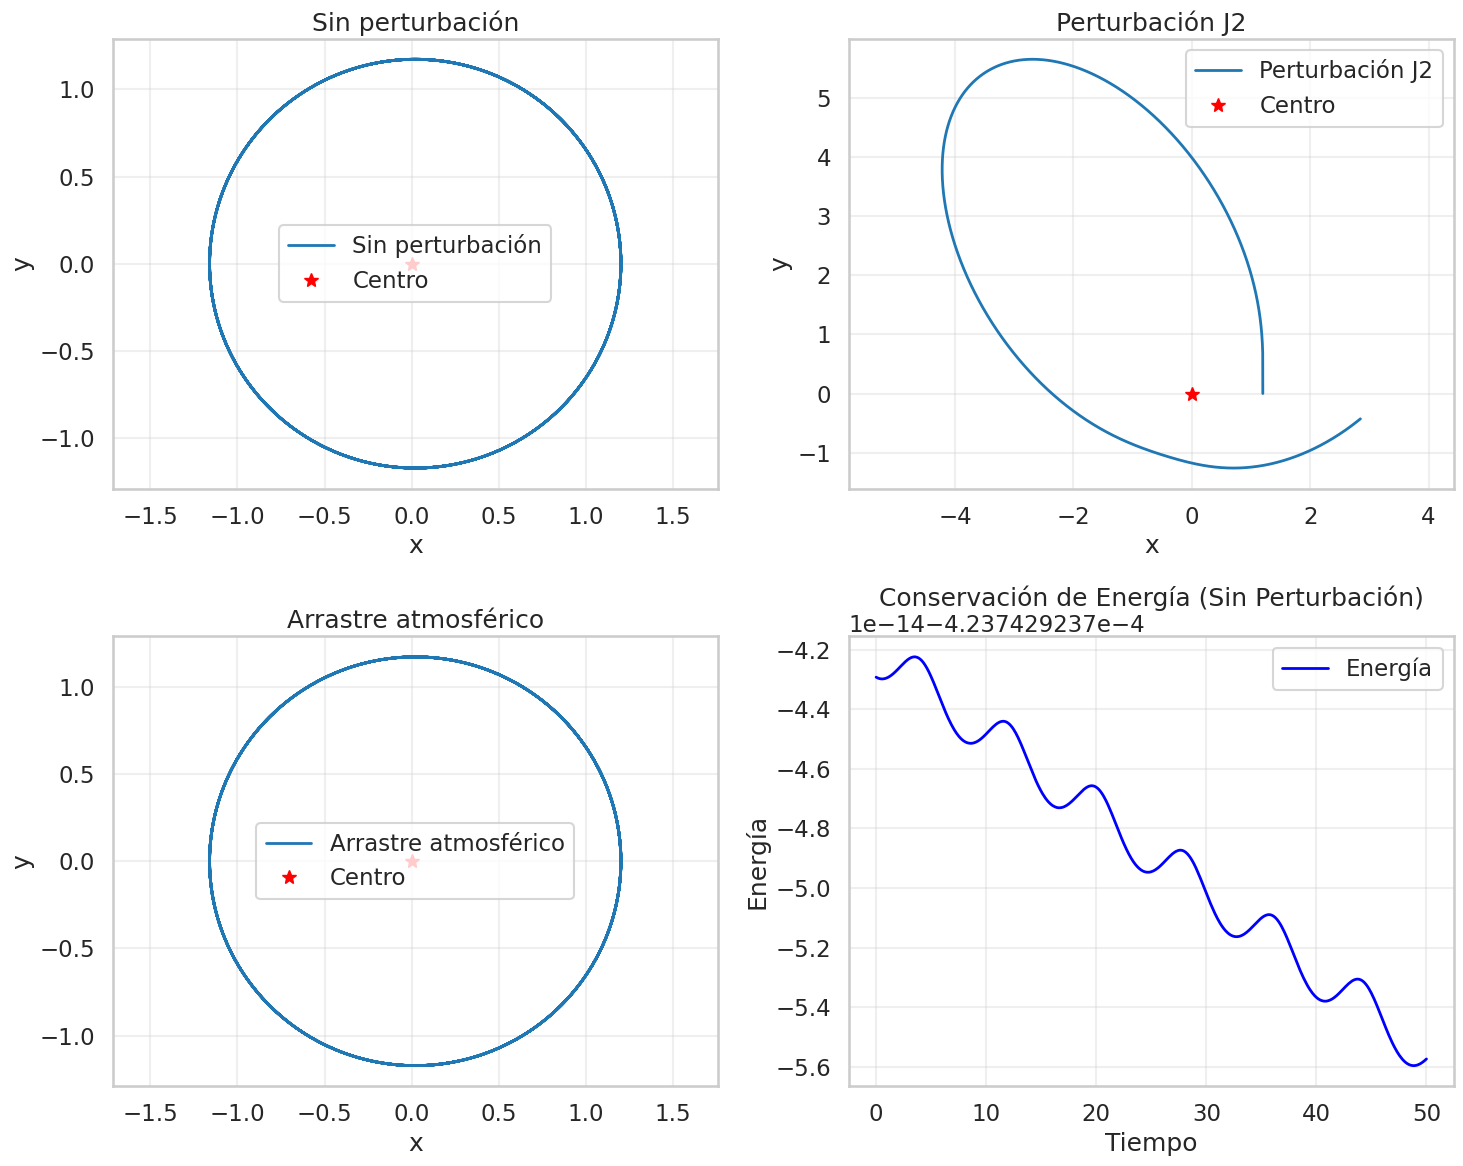

Análisis paramétrico de perturbaciones...


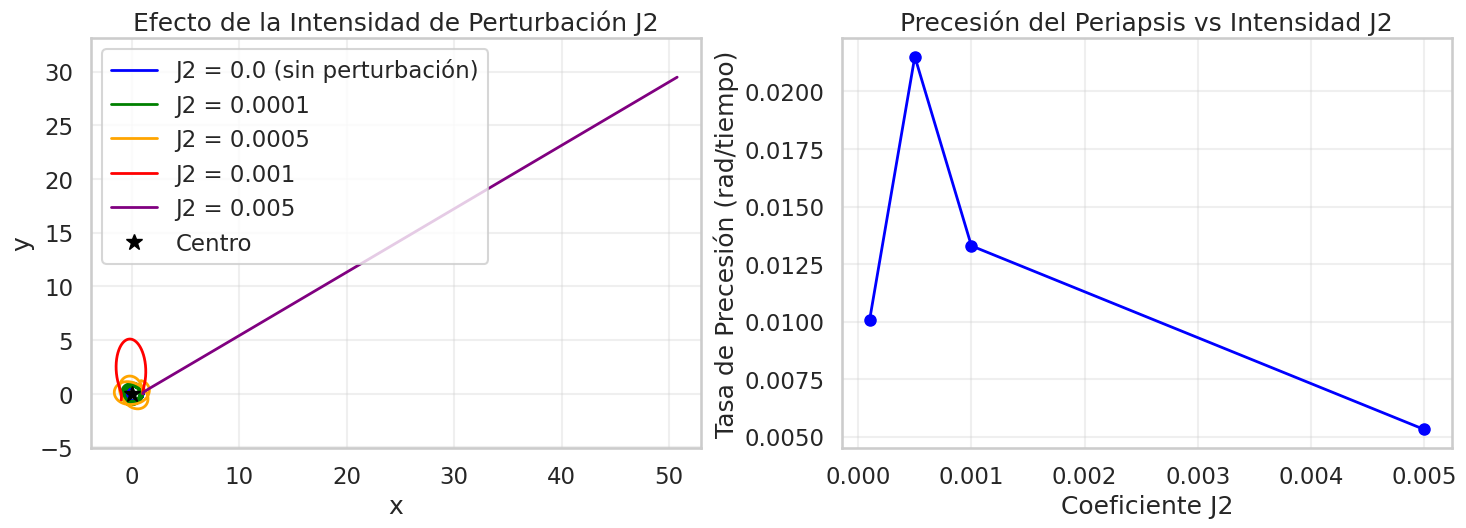

In [ ]:
class PerturbedTwoBodyProblem(TwoBodyProblem):
    """
    Extiende el problema de dos cuerpos para incluir perturbaciones.
    """

    def __init__(self, m1, m2, G=1.0, perturbation_func=None):
        super().__init__(m1, m2, G)
        self.perturbation_func = perturbation_func

    def equations_of_motion(self, t, y):
        """
        Ecuaciones de movimiento con perturbación.

        Args:
            t: tiempo
            y: vector de estado

        Returns:
            derivadas del vector de estado con perturbación
        """
        # Ecuaciones base
        dydt = super().equations_of_motion(t, y)

        # Añadir perturbación si existe
        if self.perturbation_func is not None:
            perturbation = self.perturbation_func(t, y)
            dydt[3:] += perturbation  # perturbación en el momento

        return dydt

def j2_perturbation(j2_coeff, R_planet):
    """
    Crea una función de perturbación J2 (aplanamiento planetario).

    Args:
        j2_coeff: coeficiente J2
        R_planet: radio del planeta

    Returns:
        función de perturbación
    """
    def perturbation(t, y):
        r = y[:3]
        x, y_coord, z = r
        r_mag = np.linalg.norm(r)

        if r_mag < 1e-10:  # evitar división por cero
            return np.zeros(3)

        # Perturbación J2
        factor = -1.5 * j2_coeff * (R_planet**2) / (r_mag**5)

        fx = factor * x * (5 * z**2 / r_mag**2 - 1)
        fy = factor * y_coord * (5 * z**2 / r_mag**2 - 1)
        fz = factor * z * (5 * z**2 / r_mag**2 - 3)

        return np.array([fx, fy, fz])

    return perturbation

def atmospheric_drag_perturbation(drag_coeff, reference_density, scale_height):
    """
    Crea una función de perturbación por arrastre atmosférico.

    Args:
        drag_coeff: coeficiente de arrastre
        reference_density: densidad de referencia
        scale_height: altura de escala atmosférica

    Returns:
        función de perturbación
    """
    def perturbation(t, y):
        r = y[:3]
        p = y[3:]

        altitude = np.linalg.norm(r) - 1.0  # altura sobre superficie (radio = 1)

        if altitude < 0:
            return np.zeros(3)

        # Densidad atmosférica exponencial
        density = reference_density * np.exp(-altitude / scale_height)

        # Velocidad relativa
        velocity = p / np.linalg.norm(p) if np.linalg.norm(p) > 1e-10 else np.zeros(3)

        # Fuerza de arrastre (opuesta a la velocidad)
        drag_force = -0.5 * drag_coeff * density * np.linalg.norm(velocity) * velocity

        return drag_force

    return perturbation

def simulate_perturbed_orbits():
    """
    Simula órbitas con diferentes tipos de perturbaciones.
    """
    m1, m2 = 1.0, 0.001
    G = 1.0

    # Condiciones iniciales
    r0 = np.array([1.2, 0.0, 0.0])
    v0 = np.array([0.0, 0.9, 0.1])  # órbita ligeramente inclinada
    mu = m1 * m2 / (m1 + m2)
    p0 = mu * v0
    y0 = np.concatenate([r0, p0])

    # Diferentes casos de perturbación
    cases = [
        ("Sin perturbación", TwoBodyProblem(m1, m2, G)),
        ("Perturbación J2", PerturbedTwoBodyProblem(m1, m2, G,
                                                   j2_perturbation(0.001, 1.0))),
        ("Arrastre atmosférico", PerturbedTwoBodyProblem(m1, m2, G,
                                                        atmospheric_drag_perturbation(0.01, 1e-6, 0.1)))
    ]

    plt.figure(figsize=(15, 12))

    for i, (label, problem) in enumerate(cases):
        times, states = problem.integrate(y0, (0, 50), 0.01)
        positions = states[:, :3]

        plt.subplot(2, 2, i+1)
        plt.plot(positions[:, 0], positions[:, 1], linewidth=2, label=label)
        plt.plot(0, 0, 'r*', markersize=10, label='Centro')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(label)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')

        # Análisis de conservación para el caso sin perturbación
        if i == 0:
            energies, L_values = problem.compute_conserved_quantities(states)

            plt.subplot(2, 2, 4)
            plt.plot(times, energies, 'b-', label='Energía', linewidth=2)
            plt.xlabel('Tiempo')
            plt.ylabel('Energía')
            plt.title('Conservación de Energía (Sin Perturbación)')
            plt.grid(True, alpha=0.3)
            plt.legend()

    plt.tight_layout()
    plt.show()

# Análisis paramétrico de perturbaciones
def parametric_perturbation_analysis():
    """
    Analiza el efecto de diferentes intensidades de perturbación.
    """
    m1, m2 = 1.0, 0.001
    G = 1.0

    # Condiciones iniciales
    r0 = np.array([1.0, 0.0, 0.0])
    v0 = np.array([0.0, 0.8, 0.0])
    mu = m1 * m2 / (m1 + m2)
    p0 = mu * v0
    y0 = np.concatenate([r0, p0])

    # Diferentes intensidades de perturbación J2
    j2_values = [0.0, 0.0001, 0.0005, 0.001, 0.005]
    colors = ['blue', 'green', 'orange', 'red', 'purple']

    plt.figure(figsize=(15, 10))

    # Gráfico principal
    plt.subplot(2, 2, 1)
    for j2, color in zip(j2_values, colors):
        if j2 == 0:
            problem = TwoBodyProblem(m1, m2, G)
            label = f'J2 = {j2} (sin perturbación)'
        else:
            problem = PerturbedTwoBodyProblem(m1, m2, G, j2_perturbation(j2, 1.0))
            label = f'J2 = {j2}'

        times, states = problem.integrate(y0, (0, 30), 0.01)
        positions = states[:, :3]

        plt.plot(positions[:, 0], positions[:, 1],
                color=color, linewidth=2, label=label)

    plt.plot(0, 0, 'k*', markersize=12, label='Centro')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Efecto de la Intensidad de Perturbación J2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')

    # Análisis de precesión del periapsis
    plt.subplot(2, 2, 2)
    precession_rates = []

    for j2 in j2_values[1:]:  # excluir caso sin perturbación
        problem = PerturbedTwoBodyProblem(m1, m2, G, j2_perturbation(j2, 1.0))
        times, states = problem.integrate(y0, (0, 100), 0.01)

        # Calcular ángulo del periapsis en función del tiempo
        angles = []
        for state in states[::100]:  # submuestrear para eficiencia
            r = state[:3]
            angle = np.arctan2(r[1], r[0])
            angles.append(angle)

        # Estimar tasa de precesión
        if len(angles) > 1:
            precession_rate = (angles[-1] - angles[0]) / (times[len(angles)*100-100] - times[0])
            precession_rates.append(abs(precession_rate))
        else:
            precession_rates.append(0)

    plt.plot(j2_values[1:], precession_rates, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Coeficiente J2')
    plt.ylabel('Tasa de Precesión (rad/tiempo)')
    plt.title('Precesión del Periapsis vs Intensidad J2')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Ejecutar simulaciones
    print("Simulando órbitas básicas...")
    compare_orbits()

    print("Simulando órbitas perturbadas...")
    simulate_perturbed_orbits()

    print("Análisis paramétrico de perturbaciones...")
    parametric_perturbation_analysis()